In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dictionary = pickle.load(fo, encoding='bytes')
    return dictionary

def load_data(path , dataset):
    if dataset=="cifar":
        X_train = []
        y_train = np.empty((0,10), int)
        for i in range(1,6):
            currentFile = unpickle(path+"/cifar-10-batches-py/data_batch_"+ str(i))
            current_X = currentFile[b'data']
            X_train.extend( current_X )
            current_labels = np.array(currentFile[b'labels'])
            current_y = np.squeeze(np.eye(10)[current_labels.reshape(-1)])
            y_train = np.vstack((y_train, current_y))

        testFile = unpickle(path+"/cifar-10-batches-py/test_batch")
        X_test = testFile[b'data']
        labels = np.array(testFile[b'labels'])
        y_test = np.squeeze(np.eye(10)[labels.reshape(-1)])

        return np.array(X_train)/255, np.array(X_test)/255, y_train , y_test

    if dataset=="mnist":
        df = None
        y_train = []
        for i in range( 10 ):
            tmp = pd.read_csv( path + '/mnist/train%d.txt' % i, header=None, sep=" " )
            hot_vector = [ 1 if j == i else 0 for j in range(10) ] 
            for j in range( tmp.shape[0] ):
                y_train.append( hot_vector )   
            if i == 0:
                df = tmp
            else:
                df = pd.concat( [df, tmp] )
        train_data = df.values
        y_train = np.array( y_train )

        df = None
        y_test = []
        for i in range( 10 ):
            tmp = pd.read_csv( path +'/mnist/test%d.txt' % i, header=None, sep=" " )
            hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
            for j in range( tmp.shape[0] ):
                y_test.append( hot_vector )  
            if i == 0:
                df = tmp
            else:
                df = pd.concat( [df, tmp] )
        test_data = df.values
        y_test = np.array( y_test )

        return train_data.astype(float)/255, test_data.astype(float)/255, y_train, y_test

In [2]:
def softmax( x, ax=1 ):
    m = np.max( x, axis=ax, keepdims=True )    #max per row
    p = np.exp( x - m )
    return ( p / np.sum(p,axis=ax,keepdims=True) )

class oneLayerMLP:
    
    def __init__(self, hiddenUnits , activationFunction):
        self.M = hiddenUnits
        self.h , self.hDeriv = self.getFunctions(activationFunction)

        
    def getFunctions(self,activationName):                  #returns the activation and the derivative function
        if activationName=="softplus":
           return lambda x: np.log(1+np.exp(x)) , lambda x: 1/(1+np.exp(-x))
        elif activationName=="tanh": 
            return lambda x: np.tanh(x) , lambda x: 1-np.power(np.tanh(x),2)
        elif activationName=="cos":
            return lambda x: np.cos(x) , lambda x: -np.sin(x)
        else:
            print("Wrong input, the options are: softplus,tanh,cos")
            return lambda x: 0  
        
        
    def forward_propagation(self ,w1, w2, x):
        z = self.h(x.dot(w1.T) )  
        z = np.hstack(( np.ones((z.shape[0],1)) , z ))        #append the bias unit
        y = softmax( z.dot(w2.T) )
        return z, y

    def backward_propagation( self, x, t, z, y, w1, w2 , l):
        cost = np.sum(np.log(y)*t) - (l/2) * ( np.sum( np.square( w1 ) ) +  np.sum( np.square( w2 ) ) )    
        error = t-y
        dW1 = ( error.dot(w2[:,1:]) * self.hDeriv( x.dot(w1.T)) ).T.dot(x) - l*w1
        dW2 = error.T.dot(z) - l*w2
        return cost, dW1, dW2   
    
    
    def train(self , X_train, y_train, lRate , train_epochs, batchSize, l):
        X_train = np.append(np.ones((X_train.shape[0], 1)), X_train, axis=1)        #append the bias unit
        lRate = lRate / batchSize
        self.K = y_train.shape[1]
        self.D = X_train.shape[1]
        self.costs = [] 
        s1 = np.sqrt(2/self.D)                                                      #weight initialization
        s2 = np.sqrt(2/self.M + 1)       
        self.w1 = np.random.uniform(-s1 ,s1  , (self.M,self.D)) 
        self.w2 = np.random.uniform(-s2 ,s2  , (self.K,self.M+1))    
        
        for e in range(train_epochs):
            print("epoch: ", e)
            epochCosts = []
            for batchX,batchT in self.createMiniBatches(X_train, y_train, batchSize, self.K):
                z,y = self.forward_propagation(self.w1, self.w2, batchX)
                cost, dW1, dW2 = self.backward_propagation( batchX, batchT, z, y, self.w1, self.w2 , l)
                self.w1 = self.w1 + lRate * dW1
                self.w2 = self.w2 + lRate * dW2
                epochCosts.append(cost)
            self.costs.append( sum(epochCosts)/batchSize )
    
    
    def createMiniBatches(self, x, t, batchSize, K):         #split x,t to mini batches
        stacked = np.hstack((x, t ))
        np.random.shuffle(stacked)  
        batchesList = []
        i=0
        while i<stacked.shape[0]:
            if (i+batchSize<stacked.shape[0]):
                batchesList.append(stacked[i:i+batchSize])
            else:
                batchesList.append( stacked[i:])

            i+=batchSize

        batchesList = [ [ batch[:,:-K] , batch[:,-K:] ]  for batch in batchesList  ]
        return batchesList
    
    
    def calculate_accuracy(self,X_test, t_test):
        X_test = np.hstack(( np.ones((X_test.shape[0],1)) , X_test ))
        _ , y = self.forward_propagation(self.w1 ,self.w2 ,X_test )        
        return np.mean( np.argmax(y,1) == np.argmax(t_test,1) )
    
    
    def gradcheck(self,X,t, l):
        w1 = np.ones((self.M,X.shape[1]+1))
        w2 = np.ones((t.shape[1],self.M+1))   
        old_W1 = np.copy(w1)
        old_W2 = np.copy(w2)
        epsilon = 1e-6
        
        X =  np.hstack(( np.ones((X.shape[0],1)) , X ))
        _list = np.random.randint(X.shape[0], size=5)
        x_sample = np.array(X[_list,:])
        t_sample = np.array(t[_list,:])
        
        z,y = self.forward_propagation( w1 , w2,x_sample)
        Ew, dW1 , dW2 = self.backward_propagation(x_sample, t_sample, z,y , w1 , w2,l)
        num_dW1 = np.zeros(dW1.shape)
        num_dW2 = np.zeros(dW2.shape)

        for k in range(num_dW1.shape[0]):
            for d in range(num_dW1.shape[1]):
                #add epsilon to the w[k,d]
                w1 = np.copy(old_W1)
                w1[k, d] += epsilon
                z,y = self.forward_propagation( w1 , w2,x_sample)
                e_plus, _ , _ = self.backward_propagation(x_sample, t_sample, z,y, w1 , w2,l)

                #subtract epsilon to the w[k,d]
                w1 = np.copy(old_W1)
                w1[k, d] -= epsilon
                z,y  = self.forward_propagation( w1 , w2,x_sample)
                e_minus, _ , _ =self.backward_propagation(x_sample, t_sample, z,y , w1 , w2,l)

                #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
                num_dW1[k, d] = (e_plus - e_minus) / (2 * epsilon)
                            
        w1 = np.copy(old_W1)
        z,y  = self.forward_propagation( w1 , w2, x_sample)
        Ew, dW1 , dW2 = self.backward_propagation(x_sample, t_sample, z, y ,w1 ,w2 ,l)
        for k in range(num_dW2.shape[0]):
            for d in range(num_dW2.shape[1]):

                #add epsilon to the w[k,d]
                w2 = np.copy(old_W2)
                w2[k, d] += epsilon
                z,y  = self.forward_propagation( w1 , w2,x_sample)
                e_plus, _ , _ = self.backward_propagation(x_sample, t_sample, z,y , w1 , w2,l)

                #subtract epsilon to the w[k,d]
                w2 = np.copy(old_W2)
                w2[k, d] -= epsilon
                z,y  = self.forward_propagation( w1 , w2,x_sample)
                e_minus, _ , _ = self.backward_propagation(x_sample, t_sample, z,y , w1 , w2,l)

                #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
                num_dW2[k, d] = (e_plus - e_minus) / (2 * epsilon)
            

        w2 = np.copy(old_W2)
        return ( dW1, num_dW1 , dW2 , num_dW2 )
        
        

In [3]:
mlp = oneLayerMLP(100,"softplus")                # an mlp instance for basic testing

In [5]:
X_train, X_test, y_train, y_test = load_data("data","mnist")

In [12]:
mlp.train(X_train, y_train, 0.001, 20, 100, 0.1)


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19


Accuracy:  0.908


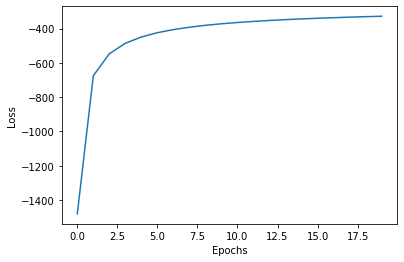

In [13]:
acc = mlp.calculate_accuracy(X_test, y_test)
plt.plot( np.arange(len(mlp.costs)),mlp.costs )
plt.xlabel("Epochs")
plt.ylabel("Loss")

print("Accuracy: ", acc)

In [6]:
grads = oneLayerMLP(20,"cos").gradcheck(X_train, y_train,0.1)          #run gradcheck on a new mlp instance

In [7]:
print("Difference between approximate and numerical gradient of W1: " , np.sum(np.abs(grads[0]-grads[1])) )
print("Difference between approximate and numerical gradient of W2: " , np.sum(np.abs(grads[2]-grads[3])) )

Difference between approximate and numerical gradient of W1:  0.000539428874353487
Difference between approximate and numerical gradient of W2:  4.941553927273468e-06


In [4]:
X_train, X_test, y_train, y_test = load_data("data","cifar")

In [5]:
mlp.train(X_train, y_train, 0.001, 20, 100, 0.1)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19


Accuracy:  0.4078


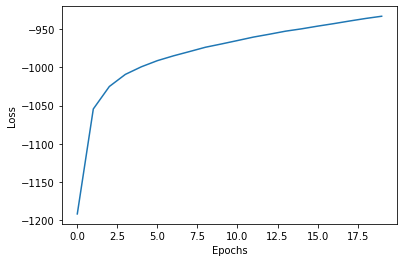

In [6]:
acc = mlp.calculate_accuracy(X_test, y_test)
plt.plot( np.arange(len(mlp.costs)),mlp.costs )
plt.xlabel("Epochs")
plt.ylabel("Loss")

print("Accuracy: ", acc)

In [ ]:
testHyperparameters()

In [3]:
def testHyperparameters():
    cols = ['DataSet', 'Hidden Layers (M)', 'Activation Function','epochs','Learning rate' , 'Regularization' , "Error" ]
    datasets = ["mnist","cifar"]
    m_vals = [100,200,300]
    activations = ["softplus" , "tanh" , "cos"]
    epochs = [10,20]
    rates = [0.01 , 0.001]
    l_vals = [0.1]
    rows=[]
    i = 0
    for dataset in datasets:
        X_train, X_test, y_train, y_test = load_data("data",dataset)
        for m in m_vals:
            for activation in activations:
                for epoch in epochs:
                    for rate in rates:
                        for l in l_vals:
                            
                            mlp = oneLayerMLP(m,activation)
                            mlp.train(X_train, y_train, rate, epoch, 100, l)
                            err = 1-mlp.calculate_accuracy(X_test, y_test)
                            rows.append([dataset,m,activation,epoch,rate,l,err])
                            i+=1
                            print(i)
                            
    df = pd.DataFrame(rows,columns =cols)
    df.to_csv("Results.csv", index=False)
    


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
1
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
2
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
3
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
4
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
5
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
6
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
ep

epoch:  19
52
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
53
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
54
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
55
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
56
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
57
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
58
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoc